In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
#загружаем данные
import requests
from urllib.parse import urlencode


base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
data_1 = 'https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'
data_2 = 'https://disk.yandex.ru/d/jmJxR8yhwCXlaw'
data_3 = 'https://disk.yandex.ru/d/DYd4M5b_8RETsA'
data_4 = 'https://disk.yandex.ru/d/lqHnH8NOZ458iw'

In [3]:
# Получаем загрузочную ссылку для data_1 (содержит информацию об оценках в тесте)
df_final_url = base_url + urlencode(dict(public_key=data_1))
response = requests.get(df_final_url)
df_download_url = response.json()['href']

# Получаем загрузочную ссылку для data_2 (содержит список предметов по семестрам)
df_final_url_2 = base_url + urlencode(dict(public_key=data_2))
response = requests.get(df_final_url_2)
df_download_url_2 = response.json()['href']

# Получаем загрузочную ссылку для data_3 (содержит результаты тестов студентов)
df_final_url_3 = base_url + urlencode(dict(public_key=data_3))
response = requests.get(df_final_url_3)
df_download_url_3 = response.json()['href']

# Получаем загрузочную ссылку для data_4 (содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре)
df_final_url_4 = base_url + urlencode(dict(public_key=data_4))
response = requests.get(df_final_url_4)
df_download_url_4 = response.json()['href']


In [4]:
#считываем датафрейм, который содержит результаты тестов студентов

student_assessment = pd.read_csv(df_download_url_3)
student_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [5]:
#1. Узнаем сколько студентов успешно сдали только один курс (успешная сдача — это зачёт по курсу на экзамене)

In [6]:
#cоздаем столбец 'successfully_passed', который отображает количество успешно сданных курсов для каждого студента

student_assessment['successfully_passed'] = student_assessment['score'] >= 40

In [7]:
#группируем по студентам и кол-ву сданных курсов у каждого
#но я не учитываю, что может быть факт перезачета теста с прошлого семестра
#в тз поставлена задача посчитать вообще всех студентов, надо уточнить этот вопрос более конкретно у продакт-менеджера

total_passed_students_successfully = student_assessment.groupby('id_student', as_index = False) \
                                                       .agg({'successfully_passed':'sum'})

In [8]:
#находим количество студентов, успешно сдавших только один курс

one_course_passed = total_passed_students_successfully.query('successfully_passed == 1')
one_course_passed.shape

#таким образом, количество студентов, которые успешно сдали только один курс, равно 2013

(2013, 2)

In [9]:
#2. Выявим самый сложный и самый простой экзамен: 
#найдем курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью

In [10]:
#предварительно найдем кол-во всех попыток сдать экзамен, в разрезе по экзаменам

total_passed_tests = student_assessment.groupby('id_assessment', as_index = False) \
                                       .agg({'score':'count'})

In [11]:
#найдем кол-во попыток успешной сдачи экзамена, в разрезе по экзаменам

total_passed_assessment_tests = student_assessment.groupby('id_assessment', as_index = False) \
                                                  .agg({'successfully_passed':'sum'})

In [12]:
#соединяем датафрейм total_passed_assessment_tests + total_passed_tests

total_passed = total_passed_tests.merge(total_passed_assessment_tests, how = 'inner', on='id_assessment')

#переименуем колонку, чтобы было более понятно, где какие данные

total_passed = total_passed.rename(columns = {'score': 'total_passed'})

In [13]:
#найдем завершаемость и вынесем ее в новый столбец
#завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен * 100 (так мы получим проценты)

total_passed['finalizability'] = (total_passed['successfully_passed']/total_passed['total_passed'] * 100).round(2)
total_passed.sort_values('finalizability')


,id_assessment,total_passed,successfully_passed,finalizability
43,15020,1772,1040,58.69
92,25360,448,334,74.55
85,25353,843,664,78.77
71,25339,496,392,79.03
52,24286,1346,1089,80.91
...,...,...,...,...
174,37429,559,559,100.00
147,34896,747,747,100.00
131,34879,1352,1352,100.00
143,34892,857,857,100.00


In [14]:
#считываем датафрейм, который содержит информацию об оценках в тесте

assessment = pd.read_csv(df_download_url)
assessment.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [15]:
#соединим наш полученный датафрейм total_passed с датафреймом assessment, чтобы понять к каким экзаменам относятся тесты
assessment_t = total_passed.merge(assessment, how = 'inner', on='id_assessment')
assessment_t.sort_values('finalizability').head()

#самым сложным экзаменом оказался тест с оценкой преподавателя - TMA, так как по нему меньше всего завершаемость, по разным предметам, но в основном по DDD
#самым простым экзаментом оказался тест с компьютерной оценкой - CMA, по нему 100% завершаемость, в основном по предмету FFF

,id_assessment,total_passed,successfully_passed,finalizability,code_module,code_presentation,assessment_type,date,weight
43,15020,1772,1040,58.69,BBB,2014J,TMA,19.0,0.0
92,25360,448,334,74.55,DDD,2014B,TMA,200.0,20.0
85,25353,843,664,78.77,DDD,2013J,TMA,207.0,20.0
71,25339,496,392,79.03,DDD,2013B,TMA,200.0,15.0
52,24286,1346,1089,80.91,CCC,2014B,CMA,18.0,2.0


In [16]:
#3. По каждому предмету определи средний срок сдачи экзаменов

In [17]:
#объединим информацию о датах начала семестра и информацию об оценках в тесте (student_assessment + assessment)

date_tests = assessment.merge(student_assessment, how = 'inner', on='id_assessment')
date_tests

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,successfully_passed
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0,True
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0,True
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0,True
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0,True
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0,True
...,...,...,...,...,...,...,...,...,...,...,...
173907,GGG,2014J,37437,TMA,173.0,0.0,652462,172,0,60.0,True
173908,GGG,2014J,37437,TMA,173.0,0.0,652539,176,0,75.0,True
173909,GGG,2014J,37437,TMA,173.0,0.0,653157,187,0,70.0,True
173910,GGG,2014J,37437,TMA,173.0,0.0,653252,171,0,70.0,True


In [18]:
#под сдачей понимаем последнее успешное прохождение экзамена студентом (берем за основу колонку date)
#ищем средний срок сдачи для каждого предмета, округляю до целого, так как дни

mean_date_exam = date_tests.groupby(['code_module', 'assessment_type'], as_index = False) \
                           .agg({'date':'mean'}) \
                           .sort_values('date') \
                           .round(0)

mean_date_exam = mean_date_exam.rename(columns = {'date': 'mean_date'})
mean_date_exam

,code_module,assessment_type,mean_date
11,FFF,TMA,85.0
9,EEE,TMA,91.0
8,DDD,TMA,92.0
3,CCC,CMA,93.0
2,BBB,TMA,96.0
6,DDD,CMA,100.0
0,AAA,TMA,109.0
5,CCC,TMA,113.0
13,GGG,TMA,115.0
1,BBB,CMA,119.0


In [19]:
#4. Выявить самые популярные предметы (ТОП-3) по количеству регистраций на них.
#А также предметы с самым большим оттоком (ТОП-3).

In [20]:
student_registration = pd.read_csv(df_download_url_4)
student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [21]:
#ТОП-3 самые популярные по количеству регистраций на предметы - BBB, FFF, DDD
#ТОП-3 с самым большим оттоком по количеству регистраций на предметы - AAA, GGG, EEE

count_registration_module = student_registration.groupby('code_module', as_index = False) \
                                                .agg({'date_registration':'count'}) \
                                                .sort_values('date_registration', ascending=False) \
                                                .rename(columns = {'date_registration': 'count_registration'})

In [22]:
#5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов 
#и самыми долгими средними сроками сдачи курсов

In [23]:
#выгрузим датафрейм который содержит список предметов по семестрам

courses = pd.read_csv(df_download_url_2)

In [24]:
#объединим courses + date_tests
df = date_tests.merge(courses, how = 'right', on='code_presentation')

In [25]:
#найдем семестр с самой низкой завершаемостью курсов, для этого объединим информацию по семестрам и завершаемостью

df_f = df.merge(total_passed, how = 'right', on='id_assessment')
df_15020 = df_f.query('id_assessment == "15020"')

#семестр с самой низкой завершаемостью курсов - 2014J

In [26]:
#определим семестр с самыми долгими средними сроками сдачи курсов

df_mean_date = df.query('code_module_y == "DDD" and assessment_type == "Exam"') \
                 .groupby('code_presentation', as_index=False) \
                 .agg({'date':'mean'})

#семестр с самыми долгими средними сроками сдачи курсов - 2013J

In [27]:
#6. Подробно опиши, как ты создавал кластеры
#Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров

In [28]:
#Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 
#В адаптированной кластеризации можешь выбрать следующие метрики: 
#R - среднее время сдачи одного экзамена - датафрейм = mean_date_exam
#F - завершаемость курсов - датафрейм = total_passed
#M - среднее количество баллов, получаемое за экзамен 


In [29]:
#для начала найдем M - среднее количество баллов, получаемое за экзамен

mean_score_exam = date_tests.groupby('assessment_type', as_index = False) \
                            .agg({'score':'mean'}) \
                            .sort_values('score') \
                            .rename(columns = {'score': 'Monetary'}) \
                            .round(2)
a = mean_score_exam.merge(mean_date_exam, how = 'right', on='assessment_type')
a = a.rename(columns = {'mean_date': 'Recency'})

In [30]:
x = total_passed.merge(date_tests, how = 'right', on='id_assessment')

In [31]:
x_2 = x.merge(a, how = 'right', on='assessment_type')

In [32]:
#почистила таблицу от ненужных столбцов

x_2 = x_2.drop(columns='weight')
x_2 = x_2.drop(columns='date')
x_2 = x_2.drop(columns='code_module_x')
x_2 = x_2.drop(columns='total_passed')
x_2 = x_2.drop(columns='successfully_passed_x')
x_2 = x_2.drop(columns='date_submitted')
x_2 = x_2.drop(columns='score')
x_2 = x_2.drop(columns='successfully_passed_y')
x_2 = x_2.drop(columns='id_assessment')
x_2 = x_2.drop(columns='code_presentation')
x_2 = x_2.drop(columns='assessment_type')
x_2 = x_2.drop(columns='is_banked')
x_2 = x_2.drop(columns='code_module_y')

In [33]:
rfm = x_2.rename(columns = {'finalizability': 'Frequency'})

In [34]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 92.0, 0.4: 96.0, 0.6: 109.0, 0.8: 119.0},
 'Frequency': {0.2: 93.74, 0.4: 96.3, 0.6: 98.38, 0.8: 99.41},
 'Monetary': {0.2: 72.56, 0.4: 72.56, 0.6: 72.56, 0.8: 81.03}}

In [35]:
#присвоим ранги от 1 до 5
#меньшее значение Recency лучше, тогда как для Frequency и Monetary наоборот, чем больше, тем лучше
#поэтому пишем 2 функции

def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

In [36]:
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5  

In [37]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [38]:
#объеденила оценки R, F и M в одну RFM, вынесла отдельным столбцом RFM Score

rfm['RFM_score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,Frequency,id_student,Monetary,Recency,R,F,M,RFM_score
0,98.32,11391,72.56,85.0,5,3,1,531
1,98.32,28400,72.56,85.0,5,3,1,531
2,98.32,31604,72.56,85.0,5,3,1,531
3,98.32,32885,72.56,85.0,5,3,1,531
4,98.32,38053,72.56,85.0,5,3,1,531


In [49]:
rfm_count = rfm.groupby('RFM_score', as_index=False) \
           .agg({'id_student':'count'}) \
           .sort_values('id_student') \
           .rename(columns = {'id_student': 'count_students'})

#результаты RFM анализа дали 41 кластер

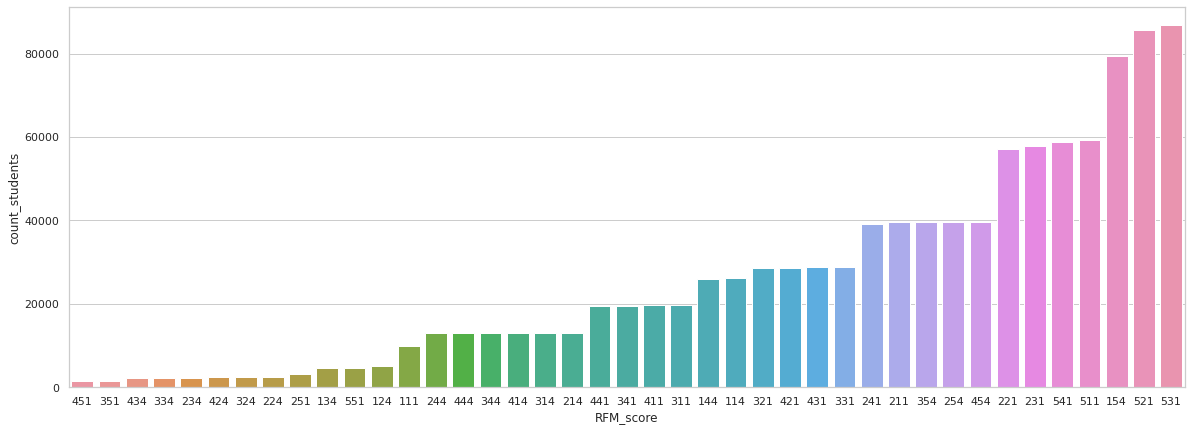

In [48]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)})


sns.barplot(x = 'RFM_score', y ='count_students', data = rfm_count)

In [50]:
#согласно графику, больше всего студентов с индексом - R=5, F=2/3, M=1, что означает быстро, эффективно и качественно
#меньше всего студентов с индексом - R=4, F=5, M=1, что означает быстро, совсем не эффективно, но при этом качественно
#могу сделать вывод, что в большей степени наше обучение качественное: 
# - так как среднее время прохождение курсов быстрое (интерпретирую это так - студенты хорошо усваивают информацию и поэтому быстро проходят экзамены, им надо меньше времени на 'подумать')
# - так же лидирующие позиции занимает индекс 531 - быстро, эффективно и качественно (так скажем 'идеальный индекс')